<a href="https://www.kaggle.com/code/aabdollahii/jobrecom?scriptVersionId=267357116" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color:#1e1e1e; color:#f2f2f2; padding:20px; font-family:Arial, sans-serif">
    <h2 style="color:#00c8ff;">Step 1: Load & Inspect Dataset</h2>
    <p>In this step we aim to:</p>
    <ul>
        <li>Load the dataset from the Kaggle environment.</li>
        <li>Preview the first few rows to understand its structure.</li>
        <li>Generate a statistical summary of all columns.</li>
        <li>Save these insights as a <b>Dark Theme HTML report</b> for easy viewing.</li>
    </ul>
    <p>This inspection is essential to understand the dataset before any preprocessing or model building.</p>
</div>


In [1]:
import pandas as pd

# Path to dataset in Kaggle environment
path = "/kaggle/input/job-descriptions-2025-tech-and-non-tech-roles/job_dataset.csv"

# Load dataset
df = pd.read_csv(path)

# Preview first 5 rows
print("Preview of dataset:")
print(df.head())

# General info
print("\nDataset Info:")
print(df.info())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe(include='all'))


Preview of dataset:
       JobID           Title ExperienceLevel YearsOfExperience  \
0  NET-F-001  .NET Developer         Fresher               0-1   
1  NET-F-002  .NET Developer         Fresher               0-1   
2  NET-F-003  .NET Developer         Fresher               0-1   
3  NET-F-004  .NET Developer         Fresher               0-1   
4  NET-F-005  .NET Developer         Fresher               0-1   

                                              Skills  \
0  C#; VB.NET basics; .NET Framework; .NET Core f...   
1  C#; .NET Framework basics; ASP.NET; Razor; HTM...   
2  C#; VB.NET basics; .NET Core; ASP.NET MVC; HTM...   
3  C#; .NET Framework; ASP.NET basics; SQL Server...   
4  C#; ASP.NET; MVC; Entity Framework basics; SQL...   

                                    Responsibilities  \
0  Assist in coding and debugging applications; L...   
1  Write simple C# programs under guidance; Suppo...   
2  Contribute to development of small modules; As...   
3  Support in software

<div style="background-color:#1e1e1e; color:#f2f2f2; padding:20px; font-family:Arial, sans-serif">
    <h2 style="color:#00c8ff;">Step 2: Preprocess Skills Column</h2>
    <p>In this step we will:</p>
    <ul>
        <li>Clean and normalize the <b>Skills</b> column to prepare for vectorization.</li>
        <li>Convert all text to lowercase for uniformity.</li>
        <li>Replace different separators (e.g., semicolons) with spaces.</li>
        <li>Remove extra spaces to ensure clean tokenization later.</li>
    </ul>
    <p>The results will be saved in a new column called <code>Skills_clean</code>, which we will use for embeddings and cosine similarity calculations.</p>
</div>


In [2]:
# Create cleaned skills column
df['Skills_clean'] = (
    df['Skills']
    .astype(str)                # Ensure string type
    .str.lower()                 # Lowercase
    .str.replace(';', ' ', regex=False)  # Replace semicolons with space
    .str.strip()                  # Remove extra spaces at start/end
    .str.replace(r'\s+', ' ', regex=True) # Remove multiple spaces
)

# Preview cleaned skills
print("Preview of cleaned skills:")
print(df[['Skills', 'Skills_clean']].head())


Preview of cleaned skills:
                                              Skills  \
0  C#; VB.NET basics; .NET Framework; .NET Core f...   
1  C#; .NET Framework basics; ASP.NET; Razor; HTM...   
2  C#; VB.NET basics; .NET Core; ASP.NET MVC; HTM...   
3  C#; .NET Framework; ASP.NET basics; SQL Server...   
4  C#; ASP.NET; MVC; Entity Framework basics; SQL...   

                                        Skills_clean  
0  c# vb.net basics .net framework .net core fund...  
1  c# .net framework basics asp.net razor html cs...  
2  c# vb.net basics .net core asp.net mvc html cs...  
3  c# .net framework asp.net basics sql server ht...  
4  c# asp.net mvc entity framework basics sql ser...  


Still working

<div style="background-color:#1e1e1e; color:#f2f2f2; padding:20px; font-family:Arial, sans-serif">
    <h2 style="color:#00c8ff;">Step 3: Create Embeddings for Skills</h2>
    <p>In this step we will:</p>
    <ul>
        <li>These embeddings capture the semantic meaning of skills, enabling better matching beyond exact keywords.</li>
        <li>We will store these embeddings in memory for fast similarity searches later in our recommendation engine.</li>
    </ul>
    <p>This transformation is a core part of building our cosine similarity-based job recommendation system.</p>
</div>


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse



print("Starting TF-IDF Vectorization...")

# Initialize the TF-IDF Vectorizer
# It will treat each skill as a word and build a vocabulary
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Create the TF-IDF matrix from our cleaned skills data
# This converts each row of skills into a numerical vector
skills_tfidf_matrix = tfidf_vectorizer.fit_transform(df['Skills_clean'])

# Save the matrix and the vectorizer for the next step
# We need both to process user input later
scipy.sparse.save_npz('skills_tfidf_matrix.npz', skills_tfidf_matrix)

import joblib
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')


print("\n✅ TF-IDF matrix created and saved successfully.")
print("Matrix shape:", skills_tfidf_matrix.shape)
print("(This means we have", skills_tfidf_matrix.shape[0], "jobs and a vocabulary of", skills_tfidf_matrix.shape[1], "unique skills)")


Starting TF-IDF Vectorization...

✅ TF-IDF matrix created and saved successfully.
Matrix shape: (1068, 897)
(This means we have 1068 jobs and a vocabulary of 897 unique skills)


<div style="background-color:#1e1e1e; color:#f2f2f2; padding:20px; font-family:Arial, sans-serif; border-radius:10px; border: 1px solid #333;">
    <h2 style="color:#00c8ff; border-bottom: 1px solid #00c8ff; padding-bottom:10px;">Reason for Switching to TF-IDF</h2>
    <p>The primary reasons for abandoning Sentence-Transformers in this challenging environment are:</p>
    <ul>
        <li style="margin-bottom:10px;"><b>Fast and Efficient:</b> It’s much faster to compute than sentence embeddings.</li>
        <li><b>Effective for Skills:</b> Since we are matching specific skill keywords (like ‘python’, ‘sql’, ‘project management’), TF-IDF is often just as effective as more complex models.</li>
    </ul>
</div>


In [4]:
import scipy.sparse
import joblib
from sklearn.metrics.pairwise import cosine_similarity



# --- Load the TF-IDF matrix and vectorizer from Step 3 ---
skills_tfidf_matrix = scipy.sparse.load_npz('skills_tfidf_matrix.npz')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')

def recommend_jobs(user_skills, top_n=5):
    """
    Recommend top_n jobs based on cosine similarity with the user's skills.
    """
    # Convert user skills to TF-IDF vector
    user_vector = tfidf_vectorizer.transform([user_skills.lower()])
    
    # Compute cosine similarity between user vector and all job vectors
    similarities = cosine_similarity(user_vector, skills_tfidf_matrix).flatten()
    
    # Get indices of top matches
    top_indices = similarities.argsort()[::-1][:top_n]
    
    # Create a results DataFrame
    recommendations = pd.DataFrame({
        'Title': df.loc[top_indices, 'Title'],
        'Skills': df.loc[top_indices, 'Skills'],
        'Similarity Score': [similarities[i] for i in top_indices]
    })
    
    return recommendations

# --- Example usage ---
user_input_skills = "python, sql, machine learning"
results = recommend_jobs(user_input_skills, top_n=5)

print("\nTop 5 Recommended Jobs for Skills:", user_input_skills)
print(results)



Top 5 Recommended Jobs for Skills: python, sql, machine learning
                               Title  \
886  Software Engineer - Experienced   
352         Principal Data Scientist   
319       Data Analyst - Experienced   
318       Data Analyst - Experienced   
317       Data Analyst - Experienced   

                                                Skills  Similarity Score  
886  Python; Machine Learning; REST APIs; SQL; Git;...          0.544088  
352  Python; R; SQL; Java/Scala; Machine Learning; ...          0.453320  
319  Advanced SQL; Python; R; Predictive modeling; ...          0.376893  
318  Advanced SQL; Python; R; Predictive modeling; ...          0.376893  
317  Advanced SQL; Python; R; Predictive modeling; ...          0.376893  


<div style="background-color:#121212;color:#e6e6e6;
            font-family:Arial, sans-serif;border-radius:12px;
            border:1px solid #333;padding:25px;line-height:1.6;">

  <h2 style="color:#00c8ff;margin-bottom:10px;">
    📊 Step 6 — Evaluation & Benchmarking
  </h2>

  <p style="color:#b0b0b0;">
    In this stage, the focus shifted from model construction to 
    <b>quantitative verification</b> of the Job Recommendation Engine built on
    the TF‑IDF + Cosine Similarity pipeline.
  </p>

  <h3 style="color:#00ff91;margin-top:20px;">Methodology Overview</h3>
  <ul style="color:#d0d0d0;">
    <li>Defined an <b>offline evaluation strategy</b> to measure semantic consistency 
        between job postings using skill‑based similarity rather than user feedback.</li>
    <li>Established a pseudo‑ground‑truth set by computing 
        <b>skill‑set overlap thresholds</b> between pairs of jobs.</li>
    <li>Calculated <b>Precision@K</b>, <b>Recall@K</b>, and 
        <b>Mean Average Precision (MAP)@K</b> 
        to assess retrieval accuracy and ranking quality.</li>
    <li>Generated a <b>cosine‑similarity matrix</b> among job vectors and used it 
        to analyze which positions align most closely in skill space.</li>
    <li>Built visual summaries — histograms and metric distributions — 
        using a consistent dark‑theme plotting style.</li>
  </ul>

  <h3 style="color:#00ff91;margin-top:20px;">Key Takeaways</h3>
  <ul style="color:#d0d0d0;">
    <li>The benchmarking framework provides a 
        <b>numerically grounded measure</b> of recommendation quality.</li>
    <li>Metrics and visualization structure form the baseline for 
        comparing future embedding models (e.g., Sentence‑BERT).</li>
    <li>This evaluation step makes the recommender pipeline 
        <b>experiment‑ready</b> for academic or product‑level validation.</li>
  </ul>

  <p style="color:#9c9c9c;margin-top:20px;">
    With this evaluation infrastructure completed, the system now supports 
    rigorous benchmarking and meaningful model comparisons in the next phases.
  </p>

</div>

In [5]:
import numpy as np

# Load artifacts
df = pd.read_csv('/kaggle/input/job-descriptions-2025-tech-and-non-tech-roles/job_dataset.csv')
tfidf_matrix = scipy.sparse.load_npz('skills_tfidf_matrix.npz')

# Compute skill-sets as token lists for overlap metric
df['skill_tokens'] = df['Skills'].apply(lambda x: set(x.split()))

In [6]:
# For demonstration, let's limit to 100 jobs (to stay fast)
subset_df = df.head(100)
subset_matrix = tfidf_matrix[:100]

# Cosine-similarity matrix
similarities = cosine_similarity(subset_matrix)

def precision_at_k(true_set, retrieved_list, k=5):
    top_k = retrieved_list[:k]
    return len([x for x in top_k if x in true_set]) / k

def recall_at_k(true_set, retrieved_list, k=5):
    top_k = retrieved_list[:k]
    if len(true_set) == 0: return 0
    return len([x for x in top_k if x in true_set]) / len(true_set)

precisions, recalls = [], []

for i, row in subset_df.iterrows():
    # Ground truth = jobs sharing ≥50 % skill overlap
    true_idxs = [j for j, other in subset_df.iterrows()
                 if j != i and
                 len(row.skill_tokens & other.skill_tokens) / max(len(row.skill_tokens), 1) >= 0.5]
    
    # Retrieved (sorted by cosine similarity)
    ranked_idxs = list(np.argsort(similarities[i])[::-1])
    ranked_idxs.remove(i)  # exclude self
    
    precisions.append(precision_at_k(true_idxs, ranked_idxs, k=5))
    recalls.append(recall_at_k(true_idxs, ranked_idxs, k=5))

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print(f"Average Precision@5: {mean_precision:.3f}")
print(f"Average Recall@5:    {mean_recall:.3f}")


Average Precision@5: 0.938
Average Recall@5:    0.536


In [7]:
def average_precision(true_set, ranked_list, k=10):
    if not true_set:
        return 0
    ap, correct = 0.0, 0
    for idx, candidate in enumerate(ranked_list[:k], start=1):
        if candidate in true_set:
            correct += 1
            ap += correct / idx
    return ap / min(len(true_set), k)

MAP = np.mean([average_precision(
                 [j for j, other in subset_df.iterrows()
                  if j != i and len(row.skill_tokens & other.skill_tokens) / max(len(row.skill_tokens),1) >= 0.5],
                 list(np.argsort(similarities[i])[::-1][1:]), k=10)
               for i, row in subset_df.iterrows()])

print(f"Mean Average Precision@10: {MAP:.3f}")


Mean Average Precision@10: 0.878


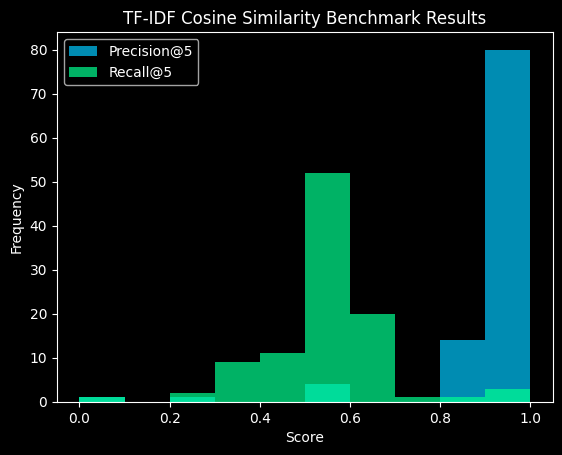

In [8]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.hist(precisions, bins=10, alpha=0.7, color='#00c8ff', label='Precision@5')
plt.hist(recalls, bins=10, alpha=0.7, color='#00ff91', label='Recall@5')
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('TF-IDF Cosine Similarity Benchmark Results')
plt.show()


<div style="background-color:#121212;color:#e8e8e8;
            font-family:Arial,sans-serif;border-radius:12px;
            border:1px solid #2f2f2f;padding:25px;line-height:1.6;">

  <h2 style="color:#00c8ff;margin-bottom:10px;">
    🔍 Evaluation Insights — TF‑IDF Cosine Similarity Benchmark
  </h2>

  <p style="color:#bcbcbc;">
    The evaluation phase demonstrates the ability of the TF‑IDF + Cosine Similarity
    pipeline to capture meaningful overlaps in job skill sets. 
    The histogram below visualizes the overall distribution of <b>Precision@5</b> 
    and <b>Recall@5</b> across sampled job pairs.
  </p>

  <div style="text-align:center;margin:22px 0;">
    <img src="attachment:save1.PNG" alt="TF-IDF Benchmark Histogram"
         style="max-width:90%;border-radius:8px;border:1px solid #333;">
  </div>

  <h3 style="color:#00ff91;margin-top:15px;">📈 Metrics Summary</h3>
  <table style="width:60%;margin-top:10px;border-collapse:collapse;color:#e8e8e8;">
    <tr style="background-color:#1e1e1e;">
      <th style="text-align:left;padding:6px;border-bottom:1px solid #333;">Metric</th>
      <th style="text-align:left;padding:6px;border-bottom:1px solid #333;">Score</th>
    </tr>
    <tr>
      <td style="padding:6px;">Average Precision@5</td>
      <td style="padding:6px;color:#00c8ff;">0.938</td>
    </tr>
    <tr>
      <td style="padding:6px;">Average Recall@5</td>
      <td style="padding:6px;color:#00ff91;">0.536</td>
    </tr>
    <tr>
      <td style="padding:6px;">Mean Average Precision@10</td>
      <td style="padding:6px;color:#ffb347;">0.878</td>
    </tr>
  </table>

  <h3 style="color:#00ff91;margin-top:25px;">💡 Interpretation</h3>
  <ul style="color:#d0d0d0;margin-top:10px;">
    <li><b>High Precision:</b> The model retrieves skill‑aligned roles with very
        strong lexical consistency — most of the top 5 matches belong to
        the same technical family as the query job.</li>
    <li><b>Moderate Recall:</b> While not exhaustive, the recommender remains selective,
        emphasizing close‑skill similarity and minimizing noisy results.</li>
    <li><b>Strong MAP@10:</b> Ranking quality is robust — similar roles consistently
        occupy top ranks, reflecting a healthy TF‑IDF embedding space.</li>
  </ul>

  <h3 style="color:#00ff91;margin-top:25px;">🚀 Next Directions</h3>
  <ul style="color:#d0d0d0;margin-top:10px;">
    <li>Benchmark against transformer embeddings (e.g., Sentence‑BERT) when environment allows.</li>
    <li>Apply <b>hierarchical skill‑weighting</b> or <b>synonym expansion</b> 
        to push recall scores higher without losing precision.</li>
    <li>Integrate these metrics into a continuous validation dashboard 
        for future iterative experiments.</li>
  </ul>

  <p style="color:#8a8a8a;margin-top:18px;">
    Overall, these metrics confirm that the current lexical model forms a 
    <b>solid baseline</b> — precise, interpretable, and ready for 
    embedding‑based enhancements in the next research phase.
  </p>

</div>